# Jupyter notebook for various tasks

Necessary imports:

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from sympy.utilities.iterables import multiset_permutations

### Calculating transmittance as a function of the wavenumber
Original code by Igor. Small changes and comments by Karol.

In [83]:
# constant transmittance and reflectiveness of all the mirrors
t_mirror = 2**(-0.5)
r_mirror = 2**(-0.5)

# start and end of the plot (in wavenumber units)
plot_start = 0
plot_end = 10

# locations of all the mirrors
mirrors = [0, 1, 2**0.5]

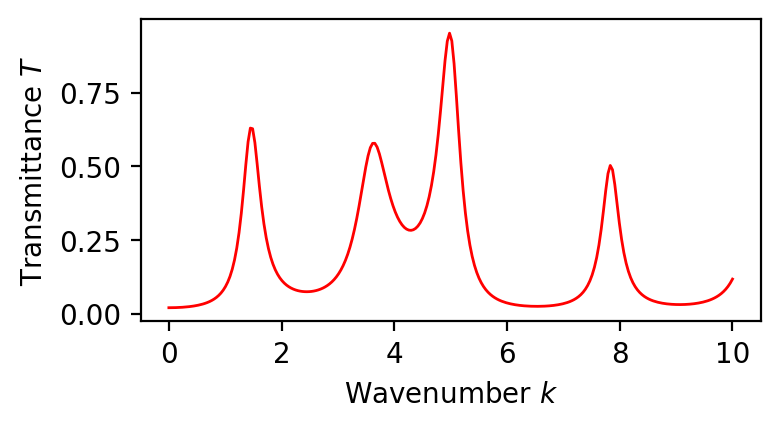

In [84]:
def tr_new(t1, r1, t2, r2):
    """
    Return a single t and r for two neighboring objects (using the composition rule for scattering matrices).
    """
   
    t = (t1 * t2) / ( 1 + np.conjugate(r1) * r2 * t1 / np.conjugate(t1) )
    r = r1 + t1 * t1 * r2 / ( 1 + np.conjugate(r1) * r2 * t1 / np.conjugate(t1) ) 
    return t, r 

def transmittance_function(t_mirror, r_mirror, positions):
    """
    Return the transmittance for a given set of mirrors as a function of k only.
    """
    
    # distances between mirrors
    dist = np.diff(positions)
 
    ### function calculating the transmittance for different wavenumbers
    def T(k):
        # mirror at the start
        t, r = t_mirror, r_mirror
        
        # now compose the current system with the next distance and the next mirror
        for l in dist:
            t, r = tr_new(t, r, np.exp(l*k*1j), 0)
            t, r = tr_new(t, r, t_mirror, r_mirror)
            
        return abs(t)**2
    
    # return the function T
    return T

    
def plot(t_mirror, r_mirror, positions, kmin, kmax, k_samples = 250):
    """
    Plot the interference pattern for a given set of mirrors, from kmin to kmax.
    """
    
    # plots the interference pattern
    T = transmittance_function(t_mirror, r_mirror, positions)
    ks = np.linspace(kmin, kmax, k_samples)

    Ts = T(ks)
    
    plt.figure(dpi=200, figsize=(4,2))
    plt.ylabel(r'Transmittance $T$')
    plt.xlabel(r'Wavenumber $k$')
    plt.plot(ks, Ts, color='r', linestyle='-', linewidth=1)
    plt.show()
    
plot(t_mirror, r_mirror, mirrors, plot_start, plot_end)

### Generating data for machine learning
#### Task 1: Classification of the number of mirrors

Original code by Michał. Changes and comments by Karol.

In [87]:
# set the range of wavenumbers:
kmin = 0
kmax = 10

# number of k-space samples (probing frequency)
k_samples = 11

# minimal and maximal number of mirrors
minMirrorCount = 3
maxMirrorCount = 10

# minimal and maximal mirror positions
mirrorMin = 0
mirrorMax = 2**0.5

# length spanned by mirrors
mirDist = mirrorMax-mirrorMin

# number of slots in which the mirrors can be placed
slotCount = 20

# Unfinished, decided to go with something else
# def mirrorLocations(mirCount,locMin,locMax,arr):
#     arr.append(locMin)
#     if (arr.length == mirCount) return arr;
#     mirrorLocations(mirCount,locMin+mirStep,locMax,arr)

###
### Run the above cells for necessary definitions!
###

# wavenumbers sampled
ks = np.linspace(kmin, kmax, k_samples)

# first line of the CSV data file: number of mirrors, first sampled value of k, second sampled value of k...
header = ["mirrorCount"] + [k for k in ks]

def get_Ts(positions):
    """
    Return the values of T for each sampled k, given the positions of the mirrors.
    """
    T = transmittance_function(t_mirror, r_mirror, positions)
    Ts = T(ks)
    return Ts

def dataGrab(pos):
    T=transmitance(t,r,pos)
    Tspace=[]
    for k in kSpace:
        Tspace.append(T(k))
    return Tspace

# generate the data and save it to a CSV file

with open('data.csv', 'w', encoding='UTF8', newline='') as f:
    file = csv.writer(f)
    
    # write the header
    file.writerow(header)
    
    # generate the data for each number of mirrors
    for mirrorCount in range(minMirrorCount, maxMirrorCount+1):
        print(f'... Generating data for {mirrorCount} mirrors ...')
        emptySlots = np.zeros(slotCount-mirrorCount)
        occupiedSlots = np.ones(mirrorCount)
        allSlots = np.append(emptySlots, occupiedSlots)
        
        for mirrorSequence in list(multiset_permutations(allSlots)):
            usedSlots = np.where(np.array(mirrorSequence) == 1)
            mirrors_positions = [ x * mirDist / ( slotCount - 1 ) + mirrorMin for x in usedSlots[0]]
            data = [mirrorCount] + list(get_Ts(mirrors_positions))
            file.writerow(data)
        print('- Done -')
    
print('Data generated.')

... Generating data for 3 mirrors ...
- Done -
... Generating data for 4 mirrors ...
- Done -
... Generating data for 5 mirrors ...
- Done -
... Generating data for 6 mirrors ...
- Done -
... Generating data for 7 mirrors ...
- Done -
... Generating data for 8 mirrors ...
- Done -
... Generating data for 9 mirrors ...
- Done -
... Generating data for 10 mirrors ...
- Done -
Data generated.


### 3D-graphing the transmission

Below is a representation of a graph like the one above, but where the middle mirror gets moved from 0.1 to sqrt(2)-0.1
It's not interactive, but you can change angle in the final line to view from different sides, or provide it with different limits to 'focus' on a specific portion/slice of the graph

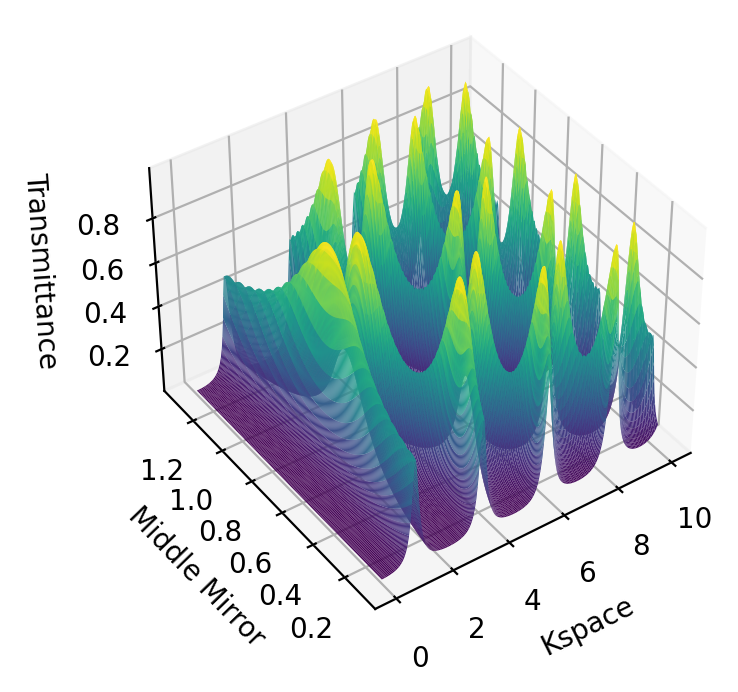

In [42]:
def transmitance2(tm,rm,middleMirror):
    pos = [0,middleMirror,2**0.5]
    dist=[]
    for i in range(len(pos)-1):
        dist.append(pos[i+1]-pos[i])
    def T(k):
        t,r=tm,rm
        for l in dist:
            t,r=tr_new(t,r,np.exp(l*k*1j),0)
            t,r=tr_new(t,r,tm,rm)
        return abs(t)**2
    return T

x = np.linspace(0, 10, 200)
y = np.linspace(0.1, 2**0.5-0.1, 200)

X, Y = np.meshgrid(x, y)
Z = transmitance2(T,R,Y)(X)


fig = plt.figure(dpi=200)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Kspace')
ax.set_ylabel('Middle Mirror')
ax.set_zlabel('Transmittance');
ax.view_init(40, -125)
